In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,List,Annotated,Dict,Literal

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
api_key=os.getenv("GROQ_API_KEY")

llm = ChatGroq(model='llama-3.1-8b-instant',api_key=api_key)

In [4]:
from pydantic import BaseModel,Field

Using structured output (like Pydantic models or LangChain's StructuredOutputParser) is extremely important when your LLM must return machine-readable, predictable data — especially JSON.
It prevents all the problems you’re currently facing:

Double curly braces

Missing keys

Extra text around JSON

Invalid JSON

Parsing errors

Below is a simple explanation + how to implement it in your case.

✅ Why structured output is important
✔ 1. Guarantees valid JSON

LLMs sometimes return:

   Extra text

   Markdown blocks

   Double braces

   Trailing commas

Structured output ensures the model must obey the schema.

✔ 2. Eliminates manual parsing + reduces errors

json.loads often breaks because the LLM returns invalid JSON.
Using a schema solves this.

✔ 3. Forces the model to return required fields

Example: always ensure evaluation + feedback exist.

✔ 4. Much easier to maintain and debug

You don’t need to write strict prompts — the schema does the work.

🧩 How to use Pydantic model with structured output (LangChain)
Step 1: Define a Pydantic model

from pydantic import BaseModel

class TweetEvaluation(BaseModel):
    evaluation: str  # "approved" or "needs_improvement"
    feedback: str
Step 2: Create a structured parser
python
Copy code
from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=TweetEvaluation)
Step 3: Add the parser instructions to the prompt
python
Copy code
format_instructions = parser.get_format_instructions()
Step 4: Use it inside the prompt
python
Copy code
messages = [
    SystemMessage(content="You are a strict tweet evaluator..."),
    HumanMessage(content=f"""
Evaluate the following tweet: {state['tweet']}

{format_instructions}
""")
]
Step 5: Parse the model’s structured response
python
Copy code
response = llm.invoke(messages)
result: TweetEvaluation = parser.parse(response.content)

In [5]:
class TweetEvaluation(BaseModel):
    evaluation : Literal["approved","needs_improvement"] 
    feedback : str

In [6]:
#it will give you a structure output same as you mentioned in the pydantic model

structured_evaluator_llm = llm.with_structured_output(TweetEvaluation)

In [7]:
import operator

In [8]:
class TweetState(TypedDict):
    #input
    topic : str
    tweet : str

    #output
    evaluation : Literal["approved","needs_improovement"]
    feedback : str
    iteration : int
    max_iteration : int
    tweet_history : Annotated[list[str], operator.add]
    feedback_history : Annotated[list[str], operator.add]

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

**Generate Tweet — purpose & guidance**

This node generates an initial tweet from the `topic` in the state.
- Inputs: `state['topic']`
- Outputs: a short `tweet` string and `tweet_history` list.
- Prompt tips: be specific about style, length, and banned formats (no Q&A).
- Keep responses short (under 280 characters) and avoid markup that complicates downstream parsing.

Example prompt guidance:
- Tone: witty, observational, slightly ironic
- Length: concise (one or two short sentences)

In [10]:
def generate_tweet(state : TweetState) -> TweetState:
    messages =[
        SystemMessage(content ="You are a funny and clever twitter influencer "),
        HumanMessage(content=f"""
                     Write a short , original, and hilarious tweet on the topic :"{state['topic']}"
                     Rules:
                     -Do not use question -answer format.
                     -Make sure tweet is less than 200 words.TextDisplayObject
                     -use obserrvational humor ,irony, sarcasm, cultural refrences
       """)
    ]

    response = llm.invoke(input=messages)

    return {'tweet' : response , 'tweet_history':[response]}

In [11]:
import json

### Notes — Structured output, invoke signature, and secrets

**Why use structured output?**
- Guarantees machine-readable JSON that matches a schema (Pydantic).
- Eliminates fragile string parsing and reduces runtime errors.
- Forces required fields (e.g., `evaluation`, `feedback`).

**Quick example (recommended flow):**

from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TweetEvaluation)
format_instructions = parser.get_format_instructions()

messages = [
    SystemMessage(content="You are a strict tweet evaluator..."),
    HumanMessage(content=f"""Evaluate the following tweet: {state['tweet']}\n\n{format_instructions}""")
]

# call model (note: use `input=` to match `.invoke()` signature)
response = structured_evaluator_llm.invoke(input=messages)

# parse and validate into Pydantic model
result: TweetEvaluation = parser.parse(response.content)

**Parsing tips:**
- Use `parser.parse(...)` instead of `json.loads` when possible — it validates types and required fields.
- If you must `json.loads`, `response.content.strip()` and removing extraneous backticks can help, but this is brittle.

**Invoke signature reminder:**
- `ChatGroq`/`BaseChatModel` implementations expect `.invoke(input=messages)` (not `messages=`).

**Secrets & safety:**
- Never hardcode API keys in notebooks. Use a local `.env` and `os.getenv('GROQ_API_KEY')`.
- Add `.env` to `.gitignore` and rotate any exposed keys immediately.
- If GitHub push protection flagged a secret, remove it from history (use `git-filter-repo` or BFG) and then force-push the cleaned history.

### Evaluator — purpose & structured parsing

This node evaluates a tweet according to a schema and returns a validated `TweetEvaluation` object.
- Inputs: `tweet` (string)
- Outputs: `evaluation` (approved | needs_improvement), `feedback` (string)

Use the `PydanticOutputParser` to produce deterministic JSON and validate the result.
Preferred flow:

1. Build `messages` including `format_instructions = parser.get_format_instructions()`
2. Call: `response = structured_evaluator_llm.invoke(input=messages)`
3. Parse: `result = parser.parse(response.content)`

If the model returns non-JSON, the parser will raise — handle this by logging the raw `response.content` and retrying with clearer instructions.

Example format instruction snippet:
```python
format_instructions = parser.get_format_instructions()
HumanMessage(content=f"Evaluate the following tweet: {state['tweet']}\n\n{format_instructions}")
```

In [ ]:

def evaluate_tweet(state :TweetState) -> TweetState:
    messages = [
        SystemMessage(content  = "You are a strict tweet evaluator who provide honest feedback"),
        HumanMessage(content=f"""
            Evaluate the following tweet : {state['tweet']}
Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}


### Optimize / Iterate — purpose & loop behavior

This node rewrites the tweet using the evaluator's feedback and increments `iteration`.
- Inputs: `tweet`, `feedback`, `iteration`
- Outputs: new `tweet`, updated `tweet_history`, and `iteration`
- Behavior: increment `iteration` and return to evaluator until `evaluation=='approved'` or `iteration >= max_iteration`.

Prompt tips: ask for concise, viral-first rewrites and explicitly state characters limit. Avoid Q&A formats.

In [14]:
def optimize_feedback(state : TweetState) -> TweetState:
    messages =[
        SystemMessage(content="You are a tweet optimizer who improves tweet based on the feedback"),
        HumanMessage(content=f"""
            Optimize the folllowing tweeet :{state['tweet']}. Use the following feedback to optimize it :{state['feedback']}.The topic for the tweet is :{state['topic']}
            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.

""")
    ]

    response = llm.invoke(input=messages)
    iteration = state['iteration']+1

    return {'tweet':response,'iteration':iteration,'tweet_history':[response]}

In [15]:
def route_evaluation(state : TweetState) -> TweetState:
    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iteration']:
        return  'approved'
    else:
        return 'needs_improvement'

In [16]:
graph = StateGraph(TweetState)

graph.add_node('generate_tweet_node',generate_tweet)
graph.add_node('evaluate_tweet_node',evaluate_tweet)
graph.add_node('optimize_feedback_node',optimize_feedback)
# graph.add_node('route_evaluation_node',route_evaluation)

graph.add_edge(START,'generate_tweet_node')
graph.add_edge('generate_tweet_node','evaluate_tweet_node')
#we are matching keyword from the output to the node names
graph.add_conditional_edges('evaluate_tweet_node',route_evaluation,{'approved':END,'needs_improvement':'optimize_feedback_node'})

# graph.add_conditional_edges('optimize_feedback_node',END)
graph.add_edge('optimize_feedback_node','evaluate_tweet_node')

In [17]:
workflow = graph.compile()
initial_state = {
    'topic':'samosa',
    'iteration':0,
    'max_iteration':3
}


In [18]:
final_state = workflow.invoke(initial_state)

response is  content='```json\n{\n  "evaluation": "approved",\n  "feedback": "This tweet effectively combines originality, humor, and punchiness. The clever observation about the elusive samosa behind the naan and judgy aunties is fresh and relatable, which is likely to resonate with the target audience. The use of hashtags like #SamosaSleuth and #PakistaniProblems adds to the humor and makes it more engaging. However, minor adjustments can be made to make it even more effective, such as avoiding generic phrases like \'Newsflash\' and making the ending more impactful."\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 562, 'total_tokens': 687, 'completion_time': 0.235464106, 'completion_tokens_details': None, 'prompt_time': 0.035005616, 'prompt_tokens_details': None, 'queue_time': 0.055168533, 'total_time': 0.270469722}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'fi

In [19]:
from IPython.display import display,Image

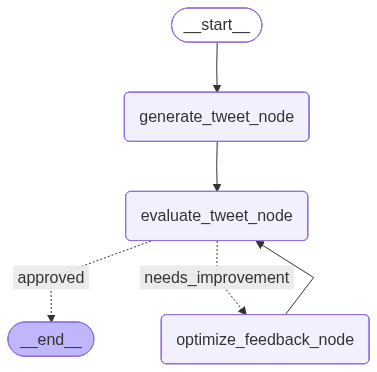

In [20]:
Image(workflow.get_graph().draw_mermaid_png())

In [21]:
final_state = workflow.invoke(initial_state, print_node=True)

response is  content='```json\n{\n  "evaluation": "approved",\n  "feedback": "This tweet is a lighthearted and relatable account of the author\'s experience perfecting their samosa-eating skills. It showcases a humorous and human side, making it easy to imagine people chuckling or laughing. The use of a personal anecdote and a dash of humor about mom\'s judgment adds to the punchiness. However, to further boost its potential for virality, the author could consider making the language even more concise and snappy, perhaps adding a bit more surprise or unexpected twist. Overall, this tweet has a great format, is within the 280-character limit, and has a good balance of originality and humor."\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 150, 'prompt_tokens': 552, 'total_tokens': 702, 'completion_time': 0.285228813, 'completion_tokens_details': None, 'prompt_time': 0.116924478, 'prompt_tokens_details': None, 'queue_time': 0.056084732, 'total_time':

##the above code will print 
#Node name

#Input state to that node

#Output returned by that node

In [22]:
final_state

{'topic': 'samosa',
 'tweet': AIMessage(content='"Just spent 10 minutes perfecting my samosa-eating skills, only to remember I\'m not competing in a Indian eating contest. My mom\'s still judging me for the 5 samosas I ate for breakfast though #SamosaLove #IndianFoodComa"', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 111, 'total_tokens': 167, 'completion_time': 0.128297695, 'completion_tokens_details': None, 'prompt_time': 0.007034985, 'prompt_tokens_details': None, 'queue_time': 0.053763345, 'total_time': 0.13533268}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b9983-31a8-7b10-9fbe-9e4ed7601458-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 111, 'output_tokens': 56, 'total_tokens': 167}),
 'evaluation': 'approved',
 'feedback': "This tweet is a lighthearted an

#This lets you see output live while the graph is running.

In [23]:
for step in workflow.stream(initial_state, print_stream=True):
    pass

response is  content='```json\n{\n  "evaluation": "approved",\n  "feedback": "This tweet is a masterclass in humor and originality. The use of a Bollywood dance to describe the reaction of the taste buds is a fresh and creative take on the typical \'food coma\' experience. The addition of the diet judging the writer with a \'told you so\' expression adds an extra layer of wit and cleverness. The tone is lighthearted and playful, making it easy to imagine this tweet resonating with a wide audience. The only minor area for improvement is the use of the hashtag #DietProblems, which feels a bit generic - consider replacing it with something more unique and specific to the tone of the tweet."\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 560, 'total_tokens': 712, 'completion_time': 0.255126979, 'completion_tokens_details': None, 'prompt_time': 0.047802365, 'prompt_tokens_details': None, 'queue_time': 0.063356704, 'total_time': 0.

In [24]:
workflow.stream(initial_state, print_stream=True)

<generator object Pregel.stream at 0x00000117F36F7990>